In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_probability as tfp

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
tf.get_logger().setLevel('WARN')

2023-06-03 20:23:11.074641: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-03 20:23:11.132598: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-03 20:23:11.133417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 20:23:12.067875: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [3]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [4]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    
    return keras.Model(inputs, reconstructions, name="vq_vae")

get_vqvae().summary()

2023-06-03 20:23:13.311343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-03 20:23:13.312611: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


In [5]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }
    

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

print(x_train.shape)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

(60000, 28, 28)


In [7]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)

vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 33s 68ms/step - loss: 1.9690 - reconstruction_loss: 0.3200 - vqvae_loss: 1.3362
Epoch 2/30
469/469 [==============================] - 32s 68ms/step - loss: 1.5325 - reconstruction_loss: 0.1399 - vqvae_loss: 1.3853
Epoch 3/30
469/469 [==============================] - 32s 68ms/step - loss: 0.7519 - reconstruction_loss: 0.1101 - vqvae_loss: 0.6340
Epoch 4/30
469/469 [==============================] - 32s 68ms/step - loss: 0.4672 - reconstruction_loss: 0.0933 - vqvae_loss: 0.3717
Epoch 5/30
469/469 [==============================] - 31s 67ms/step - loss: 0.3802 - reconstruction_loss: 0.0830 - vqvae_loss: 0.2950
Epoch 6/30
469/469 [==============================] - 31s 67ms/step - loss: 0.3426 - reconstruction_loss: 0.0759 - vqvae_loss: 0.2651
Epoch 7/30
469/469 [==============================] - 32s 68ms/step - loss: 0.3117 - reconstruction_loss: 0.0703 - vqvae_loss: 0.2401
Epoch 8/30
469/469 [==============================] - 32s 68ms

In [8]:
x_train_scaled.shape, x_test_scaled.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [9]:
trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)

In [10]:
idx

array([5067, 7450, 8379, 1335, 8012, 6479, 3709, 9457, 5520, 8096])

In [11]:
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

1/1 [==============================] - 0s 169ms/step


In [12]:
test_images

array([[[[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        ...,

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]]],


       [[[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
         [-0.5],
         ...,
         [-0.5],
         [-0.5],
         [-0.5]],

        [[-0.5],
         [-0.5],
      

In [13]:
reconstructions_test

array([[[[-0.50125754],
         [-0.49785137],
         [-0.49735677],
         ...,
         [-0.5010129 ],
         [-0.49818385],
         [-0.5001273 ]],

        [[-0.5036698 ],
         [-0.4974022 ],
         [-0.4971888 ],
         ...,
         [-0.49298573],
         [-0.49315196],
         [-0.49604452]],

        [[-0.5023195 ],
         [-0.50005287],
         [-0.4990691 ],
         ...,
         [-0.50223136],
         [-0.5002207 ],
         [-0.50404716]],

        ...,

        [[-0.5045756 ],
         [-0.50246334],
         [-0.49845034],
         ...,
         [-0.5037176 ],
         [-0.5023026 ],
         [-0.49768662]],

        [[-0.5043819 ],
         [-0.49798954],
         [-0.4998055 ],
         ...,
         [-0.50204396],
         [-0.5021315 ],
         [-0.502425  ]],

        [[-0.50207746],
         [-0.5024423 ],
         [-0.49967736],
         ...,
         [-0.5036669 ],
         [-0.5039231 ],
         [-0.5016823 ]]],


       [[[-0.50125754],


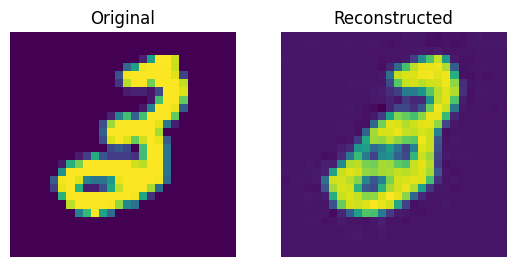

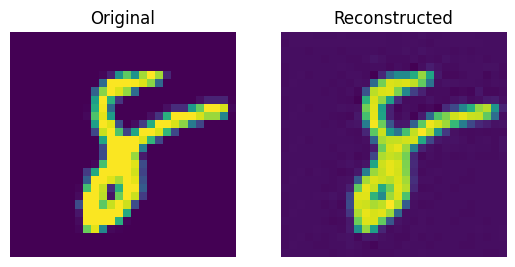

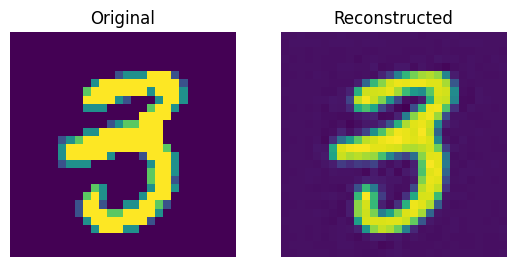

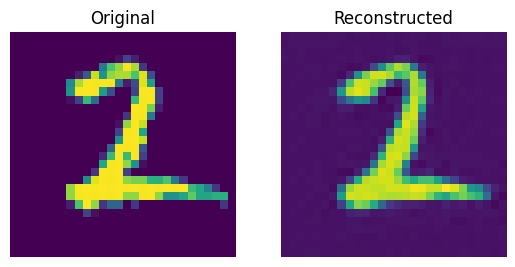

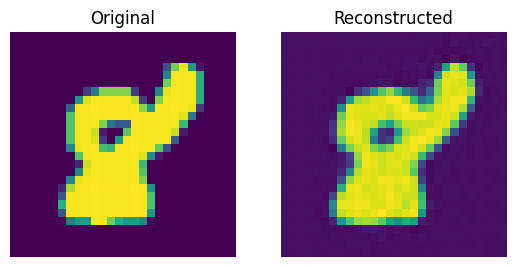

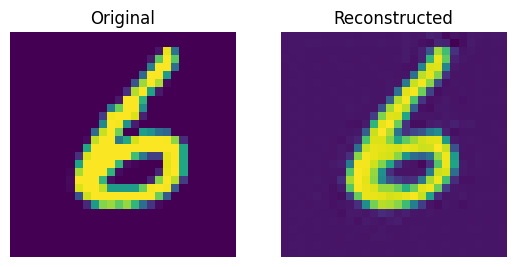

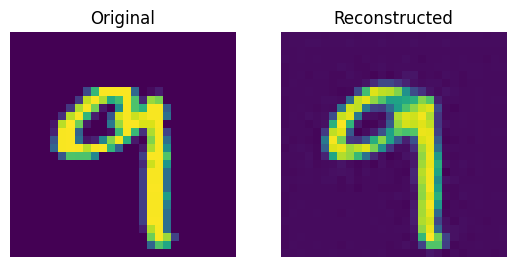

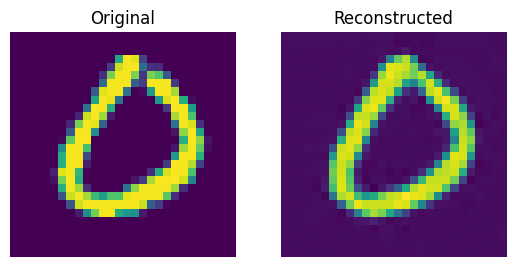

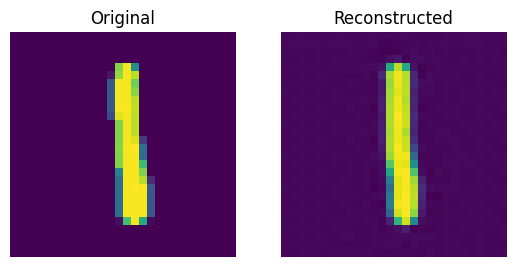

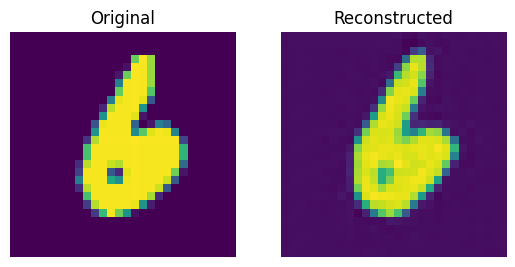

In [14]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)